# Windrose plots
This example demonstrates **polar wind visualisations** with earthkit-plots: a **frequency windrose**, a **special windrose** with density blobs, and a stylised **multi-panel hourly windrose** with runway overlays for Kloten Airport.

## Data source and setup
We query the **ECMWF IFS model** via the Open-Meteo API for **10-m wind speed and direction** at Kloten.  
Requests are cached and retried for robustness. Optionally, wind speed can be requested in knots by setting `wind_speed_unit="kn"`.

In [1]:
import requests_cache
from retry_requests import retry

import openmeteo_requests
from openmeteo_sdk.Variable import Variable

cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

url = "https://ensemble-api.open-meteo.com/v1/ensemble"
params = {
    "latitude": 47.4583,
    "longitude": 8.5480,
    "hourly": ["wind_direction_10m", "wind_speed_10m"],
    "models": "ecmwf_ifs025",
    "forecast_days": 1,
    # "wind_speed_unit": "kn"
}

responses = openmeteo.weather_api(url, params=params, verify=False)
response = responses[0]

# Print coordinates for verification
print(f"Coordinates: {response.Latitude():.2f}°N {response.Longitude():.2f}°E")
print(f"Elevation: {response.Elevation()} m asl")

Coordinates: 47.50°N 8.50°E
Elevation: 420.0 m asl


/home/pls/earthkit-plots/.venv/lib/python3.12/site-packages/urllib3/connectionpool.py:2299: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3future.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


## Parsing the API response
The hourly fields for all ensemble members are unpacked into a tidy `pandas.DataFrame`:

- `date`: common hourly time axis (UTC).  
- `wind_direction_10m_member`: direction per member (degrees).  
- `wind_speed_10m_member`: speed per member (m/s by default).

This structure makes it straightforward to select time slices and pass arrays to plotting functions.

In [2]:
import pandas as pd
import numpy as np

hourly = response.Hourly()
hourly_variables = list(map(lambda i: hourly.Variables(i), range(0, hourly.VariablesLength())))
hourly_wind_direction_10m = filter(lambda x: x.Variable() == Variable.wind_direction and x.Altitude() == 10, hourly_variables)
hourly_wind_speed_10m = filter(lambda x: x.Variable() == Variable.wind_speed and x.Altitude() == 10, hourly_variables)

hourly_data = {"date": pd.date_range(
    start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
    end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=hourly.Interval()),
    inclusive="left"
)}

for variable in hourly_wind_direction_10m:
    member = variable.EnsembleMember()
    hourly_data[f"wind_direction_10m_member{member}"] = variable.ValuesAsNumpy()
for variable in hourly_wind_speed_10m:
    member = variable.EnsembleMember()
    hourly_data[f"wind_speed_10m_member{member}"] = variable.ValuesAsNumpy()

hourly_dataframe = pd.DataFrame(data=hourly_data)

hourly_dataframe.head()

,date,wind_direction_10m_member0,wind_direction_10m_member1,wind_direction_10m_member2,wind_direction_10m_member3,wind_direction_10m_member4,wind_direction_10m_member5,wind_direction_10m_member6,wind_direction_10m_member7,wind_direction_10m_member8,...,wind_speed_10m_member41,wind_speed_10m_member42,wind_speed_10m_member43,wind_speed_10m_member44,wind_speed_10m_member45,wind_speed_10m_member46,wind_speed_10m_member47,wind_speed_10m_member48,wind_speed_10m_member49,wind_speed_10m_member50
0,2025-08-29 00:00:00+00:00,259.695221,277.943390,238.134064,241.294144,268.264343,265.072968,259.695221,253.300674,266.248352,...,17.782688,6.696387,11.275530,19.063009,11.770403,17.654688,19.469976,12.620554,20.774214,11.043261
1,2025-08-29 01:00:00+00:00,253.300674,270.000000,238.134064,237.619339,259.045990,259.592346,253.300674,246.644409,255.004868,...,15.941944,7.421590,12.303366,17.727943,11.923557,17.227419,18.129137,13.320000,18.430452,12.904882
2,2025-08-29 02:00:00+00:00,240.945480,251.564957,237.994659,230.527573,241.557175,241.821503,238.240555,232.815216,235.669724,...,11.304229,7.386582,12.074766,12.864649,10.799999,15.294703,14.489720,13.783817,13.049689,14.003028
3,2025-08-29 03:00:00+00:00,223.363464,228.576431,235.304779,222.797379,224.999893,213.690094,221.185822,216.469330,217.116943,...,8.496305,6.877789,10.883676,8.707237,8.913181,14.058450,12.738099,14.480773,9.449572,14.618837
4,2025-08-29 04:00:00+00:00,212.275620,219.472427,224.999893,212.005341,219.805527,198.435043,210.465469,208.610367,209.744797,...,8.587338,6.193674,8.404285,7.145796,6.763786,12.475961,11.183201,12.722830,9.178235,12.979984


For our windrose plot, we only need the forecast for a single point in time. We'll select the data for the first hour and convert it into two NumPy arrays: one for wind speed and one for wind direction.

In [3]:
first_hour_data = hourly_dataframe.iloc[14]
wind_speed_api = first_hour_data.filter(like='wind_speed_10m').to_numpy()
wind_direction_api = first_hour_data.filter(like='wind_direction_10m').to_numpy()

print(f"Data prepared for plotting with {wind_speed_api.shape[0]} ensemble members.")

Data prepared for plotting with 51 ensemble members.


## Frequency Windrose

The **frequency windrose** bins speeds into user-defined **radial bins** and divides direction into **angular sectors**.  

Bars show how often wind falls into each (speed, direction) bin; stacks reveal the speed distribution per direction.

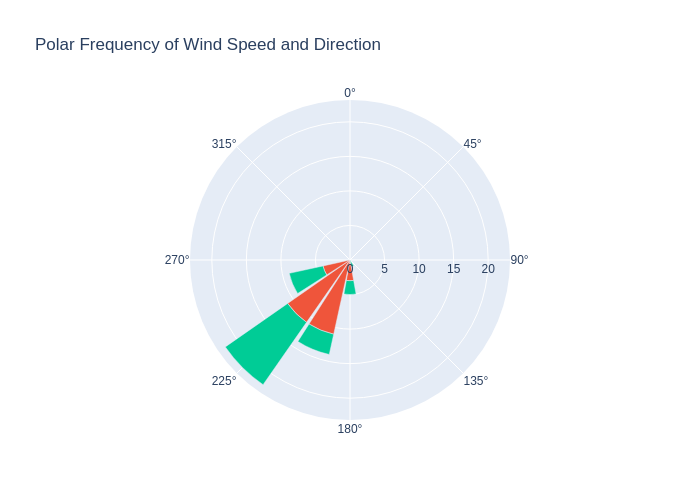

In [4]:
from earthkit.plots.interactive import Chart, polar

chart = Chart()

# Define the speed bins you want to see
speed_bins = [0, 5, 10, 15, 20, 25]

chart.polar_frequency(
    r=wind_speed_api,
    theta=wind_direction_api,
    radial_bins=speed_bins,
    n_angular_sectors=16
)

chart.title("Polar Frequency of Wind Speed and Direction")

chart.fig.update_layout(polar_barmode='stack')
chart.show(renderer="png")

## Special Windrose

The **special windrose** overlays **kernel-density "blobs"** (von Mises–based) and optional ensemble points to visualise the spread and density.


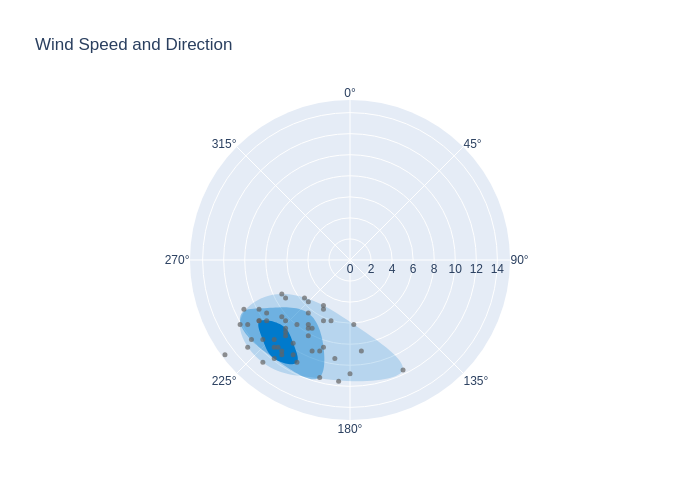

In [5]:
chart = Chart()

chart.polar(
    r=wind_speed_api.astype(np.float64),
    theta=wind_direction_api.astype(np.float64),
    show_ensemble_points=True,
    show_density_blobs=True,
    density_method="hybrid_vonmises",
)

chart.title("Wind Speed and Direction")

chart.show(renderer="png")

## Hourly windrose sequence with runways

We build a **6-panel** hourly sequence (UTC) to show short-term evolution.  
Each subplot includes:
- **Density blobs** from the ensemble,  
- An operational **limit circle**,  
- **Runway bearings** for Kloten (10/28, 14/32, 16/34), drawn as radial lines.  

This layout supports quick operational assessment of wind relative to runway orientations.

In [6]:
import plotly.graph_objects as go

# Special elements
default_klo_runways = [
    {'angle1': 98, 'angle2': 278, 'name': 'KLO 10/28'},
    {'angle1': 137, 'angle2': 317, 'name': 'KLO 14/32'},
    {'angle1': 155, 'angle2': 335, 'name': 'KLO 16/34'}
]
runway_style = {"line": {"color": "rgba(128, 128, 128, 0.7)", "width": 6}}
blob_colors = [
    'rgba(54, 57, 102, 0.8)',
    'rgba(125, 77, 119, 0.8)',
    'rgba(255, 178, 109, 0.6)'
]

# Create the Chart object and main plotting loop
chart = Chart(rows=1, columns=6, specs=[[{"type": "polar"}] * 6])
subplot_titles = [t.strftime('%H:%M (UTC)') for t in hourly_dataframe["date"].iloc[14:20]]
chart._subplot_titles = subplot_titles

for i in range(6):
    row = hourly_dataframe.iloc[i+14]
    wind_speed = row.filter(like='wind_speed_10m').to_numpy()
    wind_direction = row.filter(like='wind_direction_10m').to_numpy()

    # Add windrose density blobs
    traces = polar.windrose(
        r=wind_speed.astype(np.float64),
        theta=wind_direction.astype(np.float64),
        colors=blob_colors,
        show_ensemble_points=False,
        show_density_blobs=True,
        density_method="hybrid_vonmises",
    )
    for trace_list in traces:
        for trace in trace_list:
            chart.add_trace(trace, row=1, col=i + 1)

    # Add limit circle
    chart.add_trace(go.Scatterpolar(
        r=[10] * 361, theta=np.arange(0, 361, 1), mode='lines',
        line=dict(color='red', width=2), showlegend=False
    ), row=1, col=i + 1)

    # Add runway traces
    for runway in default_klo_runways:
        chart.add_trace(go.Scatterpolar(
            r=[0, 8], theta=[runway['angle1'], runway['angle1']], mode='lines',
            showlegend=False, **runway_style
        ), row=1, col=i + 1)
        chart.add_trace(go.Scatterpolar(
            r=[0, 8], theta=[runway['angle2'], runway['angle2']], mode='lines',
            showlegend=False, **runway_style
        ), row=1, col=i + 1)

A custom **dark layout** is applied to every subplot (grid, ticks, ranges, background).

In [7]:
import copy
from earthkit.plots.interactive.charts import DEFAULT_LAYOUT

# Custom dark layout
custom_polar_settings = copy.deepcopy(DEFAULT_LAYOUT['polar'])

custom_polar_settings['bgcolor'] = '#333333'
custom_polar_settings['angularaxis']['gridcolor'] = '#888888'
custom_polar_settings['angularaxis']['linecolor'] = 'white'
custom_polar_settings['angularaxis']['tickfont'] = {'color': 'white', 'size': 12}
custom_polar_settings['radialaxis']['gridcolor'] = '#888888'
custom_polar_settings['radialaxis']['linecolor'] = 'white'
custom_polar_settings['radialaxis']['tickfont'] = {'color': 'white', 'size': 10}
custom_polar_settings['radialaxis']['range'] = [0, 16]
custom_polar_settings['radialaxis']['angle'] = 45

# Apply to every subplot
for i in range(1, 7):
    polar_key = f"polar{i if i > 1 else ''}"
    chart.fig.update_layout({polar_key: custom_polar_settings})

# Update overall figure
chart._layout_override = {
    'paper_bgcolor': '#333333',
    'font_color': 'white',
    'height': 400,
    'margin': dict(b=20, t=80)
}

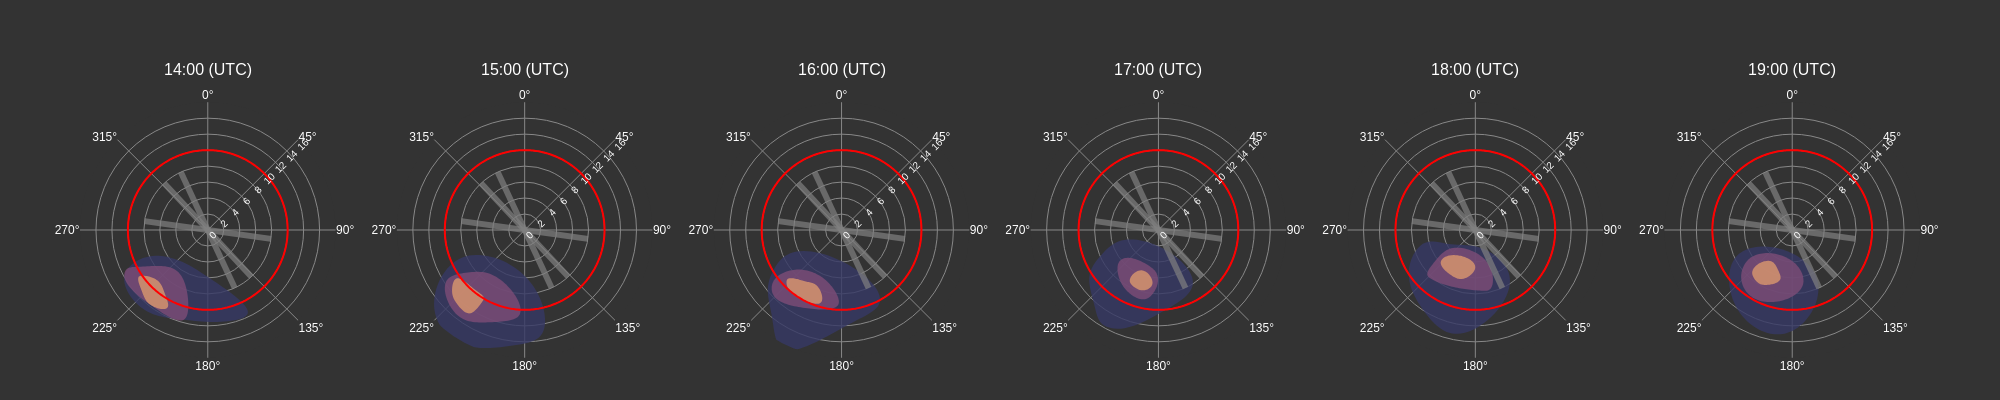

In [8]:
chart.show(renderer="png", width=2000, height=400)